# Making my own attempt at growth curve width finding
## 2023 June 22

I am trying to duplicate the basic algorithm in *A Generalist, Automated ALFALFA Baryonic Tully-Fisher Relation*, Ball++, <https://arxiv.org/abs/2212.08728>

The central channel is found by using the algorithm described in *THE ARECIBO LEGACY FAST ALFA SURVEY. IV. STRATEGIES FOR SIGNAL IDENTIFICATION AND SURVEY CATALOG RELIABILITY*, Saintonge, THE ASTRONOMICAL JOURNAL, 133:2087-2096, 2007 May.  
After reviewing this, I don't  think I want to implement it now. I suspect the values found in the APPSS database may already have been determined using it.

In [1]:
# %pip install pwlf # did this in shell

**Note this version is run on my MacBook on a file from 2023 sample of APPSS**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.integrate import cumulative_trapezoid #cumulative integration
import pwlf #piecewise linear fitting

plt.rcParams['figure.figsize'] = [9, 6]

In [3]:
%ls appss123-sample/

A102855.fits  A112350.fits  A115857.fits  A123200.fits  A333345.fits
A102969.fits  A113910.fits  A116197.fits  A124772.fits  A333370.fits
A104505.fits  A113936.fits  A122993.fits  A124887.fits  A335328.fits
A104883.fits  A115470.fits  A123069.fits  A322622.fits  A335587.fits
A105258.fits  A115479.fits  A123084.fits  A332921.fits  A336095.fits


In [4]:
# pick one at whim
g = Table.read('appss123-sample/A102969.fits')

In [5]:
g.info  #shows column structure

<Table length=2048>
   name    dtype   unit 
--------- ------- ------
   VHELIO float64 km / s
FREQUENCY float64    MHz
     FLUX float32    mJy
 BASELINE float64    mJy
   WEIGHT   int16       

In [6]:
g.meta # shows FITS header info

OrderedDict([('EXTNAME', 'Single Dish'),
             ('OBSERVAT', 'Arecibo Observatory'),
             ('TELESCOP', 'Arecibo Radio Telescope'),
             ('INSTRUME', 'L-Band Wide'),
             ('BACKEND', 'Interim Correlator'),
             ('BEAM', '3.3'),
             ('NANVALUE', -999.0),
             ('OBJECT', 'AGC 102969'),
             ('NAME', ''),
             ('HISRC', 'H004937.3+284412'),
             ('ORIGIN', 'Cornell University'),
             ('RA', 12.395),
             ('DEC', 28.739168),
             ('EQUINOX', 2000.0),
             ('RESTFRQ', 1404060000.0),
             ('BW', 24.987793),
             ('CHAN', 2048),
             ('V21SYS', 4455.65),
             ('comments',
              ['',
               'Arecibo Pisces-Perseus Supercluster Survey (APPSS)',
               'Undergraduate ALFALFA Team (UAT)',
               'Last updated: Mon Feb 28 11:32:41 2022 by GLH/MPH',
               'This spectrum has been baselined.'])])

(3955.6499999999996, 4955.65)

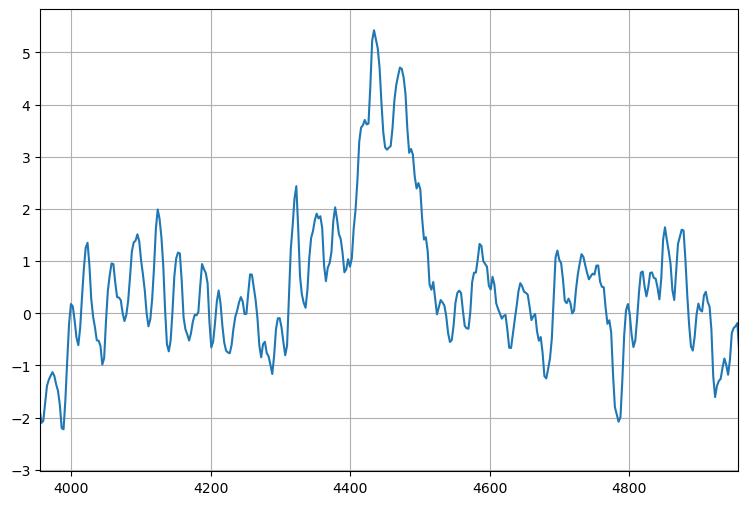

In [7]:
objname = g.meta['OBJECT']
ctr = g.meta['V21SYS']
plt.plot(g['VHELIO'], g['FLUX'])
plt.grid()
plt.xlim(ctr-500, ctr+500)

## Try making a curve of growth

2023-06-22

In [8]:

print(ctr)

4455.65


In [24]:
up = (g['VHELIO'] >= ctr) & (g['VHELIO']< ctr+150)
dn = (g['VHELIO'] <= ctr) & (g['VHELIO'] > ctr-150)
#these have to be set for the region you want the piecewise fit over

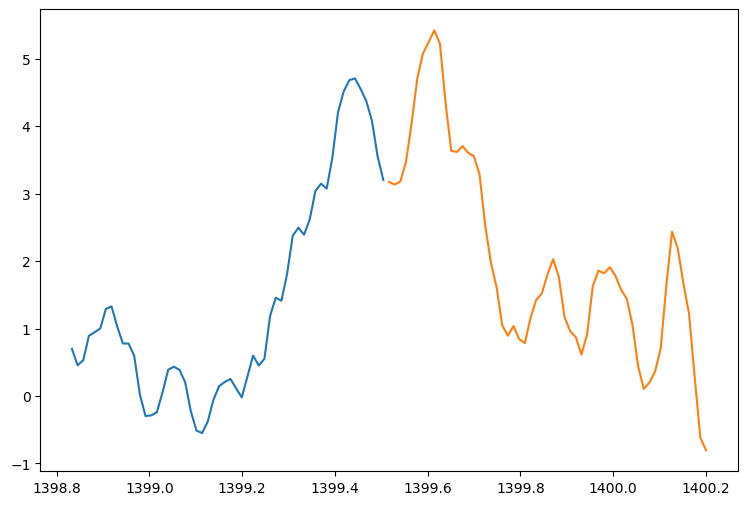

In [10]:
plt.plot(g['FREQUENCY'][up], g['FLUX'][up])
plt.plot(g['FREQUENCY'][dn], g['FLUX'][dn])


In [11]:
# note that this is just summing the array, so it sums along the FREQUENCY direction
cumdf = np.cumsum(g['FLUX'][dn])
cumuf = np.flip( np.cumsum(np.flip(g['FLUX'][up])) )

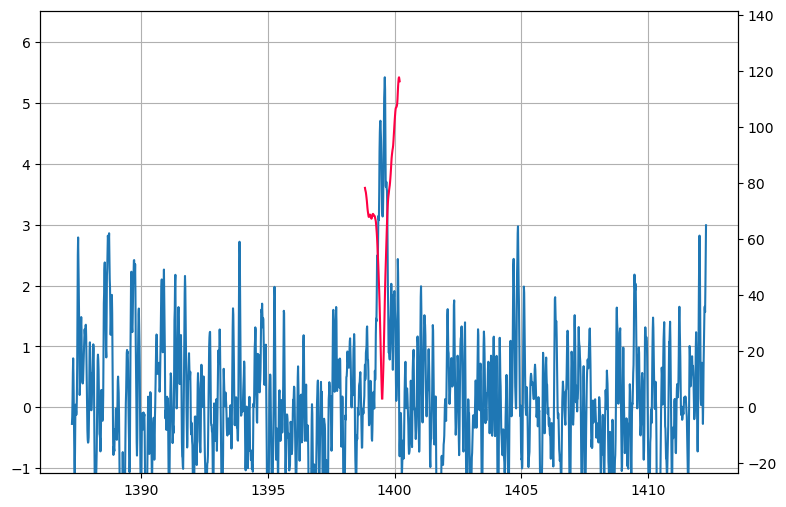

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ymax1 = 1.2*max(g['FLUX'])
ymax2 = 1.2*max(max(cumdf), max(cumuf))
ymin1, ymin2 = -ymax1/6, -ymax2/6

ax1.plot(g['FREQUENCY'], g['FLUX'])
#ax1.plot(g['FREQUENCY'][dn], g['FLUX'][dn])
ax2.plot(g['FREQUENCY'][dn], cumdf, '#ff0044')
ax2.plot(g['FREQUENCY'][up], cumuf, '#ff0044')
ax1.set_ylim(ymin1,ymax1)
ax2.set_ylim(ymin2, ymax2)
#ax1.set_xlim(1400,1404)
ax1.grid()

## Separate left and right fits

I realized (-23-07-25) that Catie's algorithm combines the left and right sides, and here I have fit them separately. To implement that, one would fold in f/v space at the center and just integrate in one direction.

In [13]:
xr = g['VHELIO'][dn]
yr = cumdf
r_pwlf = pwlf.PiecewiseLinFit(xr, yr)
r_breaks = r_pwlf.fit(2)
r_pivot = r_breaks[1]
print(r_pivot)

4413.800097666954


In [14]:
xl = g['VHELIO'][up]
yl = cumuf
l_pwlf = pwlf.PiecewiseLinFit(xl, yl)
l_breaks = l_pwlf.fit(2)
l_pivot = l_breaks[1]
print(l_pivot)

4499.256421502483


In [15]:
# y_hat = my_pwlf.predict(x_hat)
yr_fit = r_pwlf.predict(xr)
yl_fit = l_pwlf.predict(xl)

In [16]:
v_width = l_pivot - r_pivot

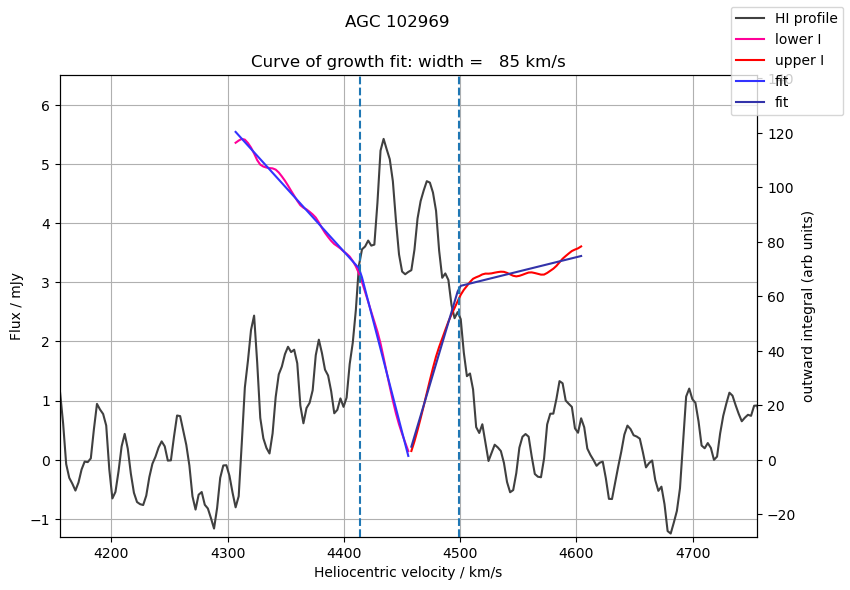

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ymax1 = 1.2*max(g['FLUX'])
ymax2 = 1.2*max(max(cumdf), max(cumuf))
ymin1, ymin2 = -ymax1/5, -ymax2/5

ax1.plot(g['VHELIO'], g['FLUX'], '#404040', label = 'HI profile')
#ax1.plot(g['FREQUENCY'][dn], g['FLUX'][dn])
ax2.plot(g['VHELIO'][dn], cumdf, '#ff0099', label='lower I')
ax2.plot(g['VHELIO'][up], cumuf, '#ff0000', label = 'upper I')
ax2.plot(xr, yr_fit, "#3333ff", label='fit')
ax2.plot(xl, yl_fit, "#3333aa", label= 'fit')
ax1.set_ylim(ymin1,ymax1)
ax2.set_ylim(ymin2, ymax2)
ax2.vlines([r_pivot, l_pivot], ymin2, ymax2, linestyles='dashed')
ax1.set_xlim(ctr-300,ctr+300)
ax1.grid()
fig.legend()
fig.suptitle(g.meta['OBJECT'])
ax2.set_title('Curve of growth fit: width = {:4.0f} km/s'.format(v_width))
ax1.set_ylabel('Flux / mJy')
ax1.set_xlabel('Heliocentric velocity / km/s')
ax2.set_ylabel('outward integral (arb units)');
plt.savefig(objname+"_cgfit.png")

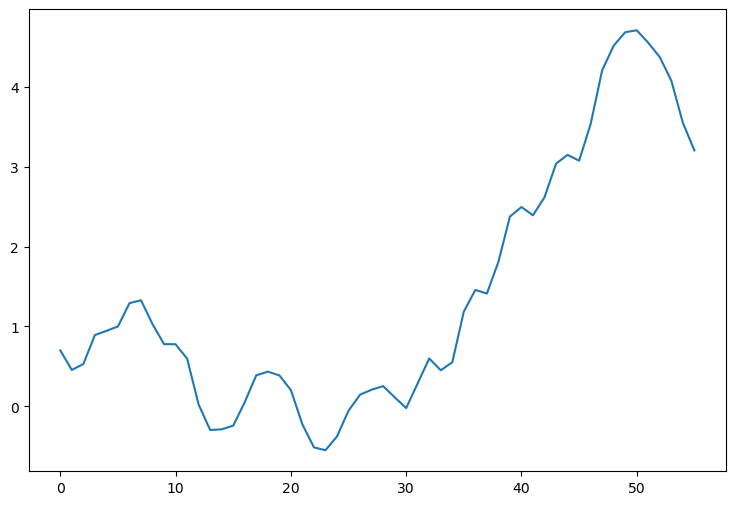

In [19]:
plt.plot(g['FLUX'][up])

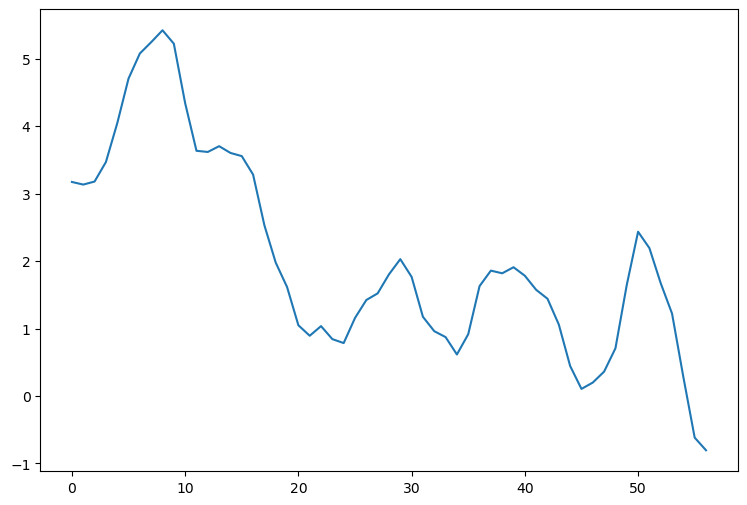

In [20]:
plt.plot(g['FLUX'][dn])

In [25]:
len(g['FLUX'][up]), len(g['FLUX'][dn])

(56, 57)

In [30]:
# It looks like you would need to find the index of the center and then go 
# an equal number of steps in each direction
np.where(np.abs(g['VHELIO'] - ctr) < 0.5)

(array([1002]),)

In [37]:
print(g['VHELIO'][1002])

4455.440478297367


In [32]:
print(ctr)

4455.65


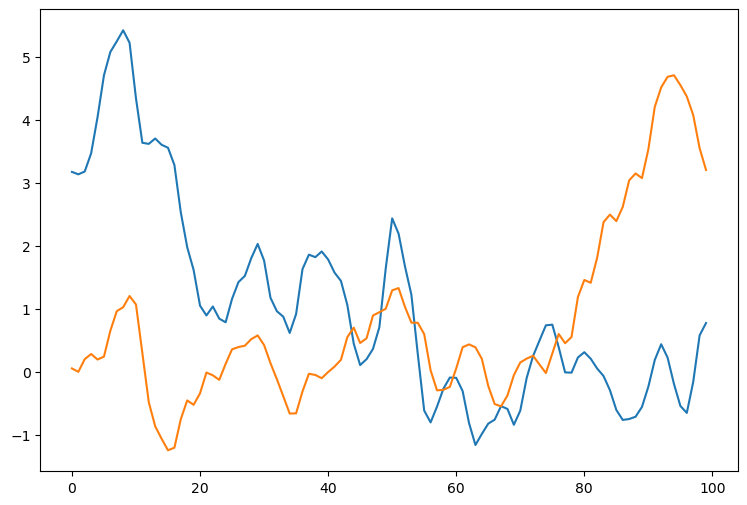

In [39]:
plt.plot(g['FLUX'][1002:1102])
plt.plot(g['FLUX'][902:1002])

In [40]:
len(g['FLUX'][1002:1102]),len(g['FLUX'][902:1002])

(100, 100)

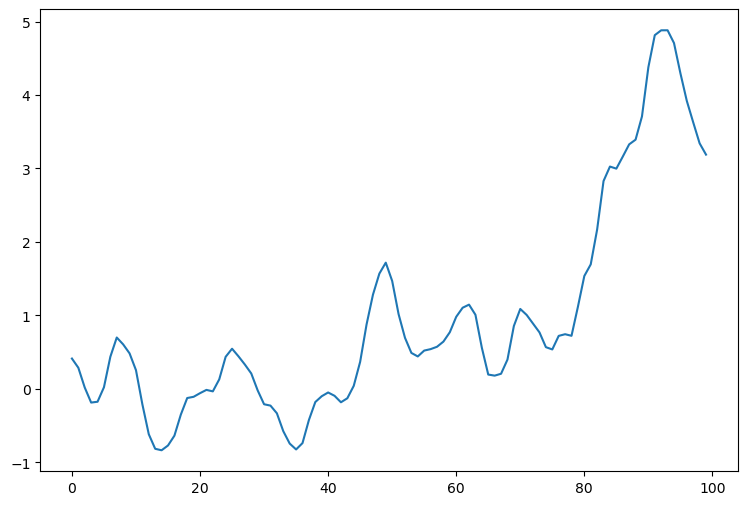

In [42]:
plt.plot((np.flip(g['FLUX'][1002:1102])+g['FLUX'][902:1002])/2)

I guess this would be the way to do it. 